In [2]:
import os
import cv2
import gdown
import shutil
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import keras_tuner as kt
from keras.models import Model
from keras.models import Sequential, load_model
from keras.applications import VGG16
from keras.optimizers import Adam, RMSprop, SGD
from keras.utils import image_dataset_from_directory
from keras.layers import Input, Flatten, Dense, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report

## Downloading Datasets

### Folder Images

### List Attribute

In [3]:
list_attribute_url = 'https://drive.google.com/file/d/1Q0kgTKibawWFUX5zTLaVUP0NJs9dcVDt/view?usp=drive_link'
gdown.download(list_attribute_url, fuzzy=True)

Downloading...
From: https://drive.google.com/uc?id=1Q0kgTKibawWFUX5zTLaVUP0NJs9dcVDt
To: D:\nitip adit\Bootcamp\Project_1\gender-classification-based-on-face-recognition\list_attribute.txt
100%|█████████████████████████████████████████████████████████████████████████████| 26.7M/26.7M [00:12<00:00, 2.07MB/s]


'list_attribute.txt'

## Splitting Dataset

In [3]:
attribute_list_df = pd.read_csv('list_attribute.txt', sep='\s+', skiprows=1, usecols=['Male'])
attribute_list_df.index.name = 'filename'
attribute_list_df.replace(to_replace=-1, value=0, inplace=True)
attribute_list_df.rename(columns={"Male": "Gender"}, inplace=True)
attribute_list_df

,Gender
filename,
000001.jpg,0
000002.jpg,0
000003.jpg,1
000004.jpg,0
000005.jpg,0
...,...
202595.jpg,0
202596.jpg,1
202597.jpg,1


In [4]:
attribute_list_df.reset_index(drop=False, inplace=True)

In [5]:
attribute_list_df

,filename,Gender
0,000001.jpg,0
1,000002.jpg,0
2,000003.jpg,1
3,000004.jpg,0
4,000005.jpg,0
...,...,...
202594,202595.jpg,0
202595,202596.jpg,1
202596,202597.jpg,1
202597,202598.jpg,0


In [6]:
images_folder = os.listdir('Images')
attribute_list_df['isExist'] = attribute_list_df['filename'].isin(images_folder)
attribute_list_df

,filename,Gender,isExist
0,000001.jpg,0,False
1,000002.jpg,0,False
2,000003.jpg,1,False
3,000004.jpg,0,False
4,000005.jpg,0,False
...,...,...,...
202594,202595.jpg,0,False
202595,202596.jpg,1,False
202596,202597.jpg,1,False
202597,202598.jpg,0,False


In [7]:
attribute_list_df.drop(attribute_list_df[attribute_list_df['isExist'] == False].index, inplace=True)
attribute_list_df

,filename,Gender,isExist
50,000051.jpg,1,True
51,000052.jpg,1,True
64,000065.jpg,1,True
165,000166.jpg,1,True
197,000198.jpg,0,True
...,...,...,...
202319,202320.jpg,0,True
202339,202340.jpg,0,True
202346,202347.jpg,0,True
202356,202357.jpg,0,True


In [8]:
attribute_list_df.reset_index(drop=True, inplace=True)
attribute_list_df

,filename,Gender,isExist
0,000051.jpg,1,True
1,000052.jpg,1,True
2,000065.jpg,1,True
3,000166.jpg,1,True
4,000198.jpg,0,True
...,...,...,...
4995,202320.jpg,0,True
4996,202340.jpg,0,True
4997,202347.jpg,0,True
4998,202357.jpg,0,True


In [3]:
images_path = 'Images'
splitted_folder = 'Splitted'
train_folder = os.path.join(splitted_folder, 'Train')
validation_folder = os.path.join(splitted_folder, 'Validation')
test_folder = os.path.join(splitted_folder, 'Test')

In [21]:
os.makedirs(train_folder, exist_ok=True)
os.makedirs(validation_folder, exist_ok=True)
os.makedirs(test_folder, exist_ok=True)

In [22]:
for index, row in attribute_list_df.iterrows():
    filename = row['filename']
    gender_label = row['Gender']

    if index % 10 < 8:
        splitted_folder = train_folder
    elif index % 10 == 8:
        splitted_folder = validation_folder
    else:
        splitted_folder = test_folder

    if gender_label == 0:
        gender_folder = os.path.join(splitted_folder, 'Female')
    else:
        gender_folder = os.path.join(splitted_folder, 'Male')

    os.makedirs(gender_folder, exist_ok=True)

    source_path = os.path.join(images_path, filename)
    destination_path = os.path.join(gender_folder, filename)
    
    print(f'Copying file {source_path} to {gender_folder}')
    shutil.copy(source_path, destination_path)

print('Splitting Datasets completed')

Copying file Images\000051.jpg to Splitted\Train\Male
Copying file Images\000052.jpg to Splitted\Train\Male
Copying file Images\000065.jpg to Splitted\Train\Male
Copying file Images\000166.jpg to Splitted\Train\Male
Copying file Images\000198.jpg to Splitted\Train\Female
Copying file Images\000201.jpg to Splitted\Train\Female
Copying file Images\000240.jpg to Splitted\Train\Female
Copying file Images\000282.jpg to Splitted\Train\Male
Copying file Images\000352.jpg to Splitted\Validation\Male
Copying file Images\000409.jpg to Splitted\Test\Male
Copying file Images\000414.jpg to Splitted\Train\Male
Copying file Images\000439.jpg to Splitted\Train\Male
Copying file Images\000444.jpg to Splitted\Train\Male
Copying file Images\000474.jpg to Splitted\Train\Male
Copying file Images\000525.jpg to Splitted\Train\Female
Copying file Images\000545.jpg to Splitted\Train\Male
Copying file Images\000559.jpg to Splitted\Train\Male
Copying file Images\000572.jpg to Splitted\Train\Male
Copying file Ima

## Preprocessing

In [4]:
image_size = (120, 120)
batch_size = 32

### Train Datasets

In [5]:
train_datasets = image_dataset_from_directory(
    directory=train_folder,
    seed=random.randint(1, 1000),
    class_names=os.listdir(train_folder),
    image_size=image_size,
    batch_size=batch_size
)

Found 4000 files belonging to 2 classes.


In [6]:
train_data_batches = [(data.numpy(), labels.numpy()) for data, labels in train_datasets]
train_data, train_labels = zip(*train_data_batches)
train_data = np.vstack(train_data)
train_labels = np.hstack(train_labels)

### Validation Datasets

In [7]:
validation_datasets = image_dataset_from_directory(
    directory=validation_folder,
    seed=random.randint(1, 1000),
    class_names=os.listdir(validation_folder),
    image_size=image_size,
    batch_size=batch_size
)

Found 500 files belonging to 2 classes.


In [8]:
validation_data_batches = [(data.numpy(), labels.numpy()) for data, labels in validation_datasets]
validation_data, validation_labels = zip(*validation_data_batches)
validation_data = np.vstack(validation_data)
validation_labels = np.hstack(validation_labels)

### Test Datasets

In [9]:
test_datasets = image_dataset_from_directory(
    directory=test_folder,
    seed=random.randint(1, 1000),
    class_names=os.listdir(test_folder),
    image_size=image_size,
    batch_size=batch_size
)

Found 500 files belonging to 2 classes.


In [10]:
test_data_batches = [(data.numpy(), labels.numpy()) for data, labels in test_datasets]
test_data, test_labels = zip(*test_data_batches)
test_data = np.vstack(test_data)
test_labels = np.hstack(test_labels)

## Build Model

In [29]:
epochs = 100
hp_opz = ['hyperband', 'RandomSearch', 'BayesianOptimization']

In [30]:
def build_vgg(hp):
    vgg = VGG16(weights='imagenet', include_top=False, input_tensor=Input(shape=(120, 120, 3)))
    vgg.trainable = False

    model = Sequential()

    for vgg_layer in vgg.layers:
        model.add(vgg_layer)

    model.add(Flatten())
    
    num_hidden_layers = hp.Int('num_hidden_layers', min_value=1, max_value=5, step=1)
    for i in range(num_hidden_layers):
        num_units = hp.Choice(f'num_units_{i}', values=[8, 16, 32, 64])
        dropout_rate = hp.Float(f'dropout_rate_{i}', min_value=0.1, max_value=0.9, step=0.1)

        if i == 0:
            model.add(Dense(num_units, activation='relu'))
        else:
            model.add(Dense(num_units, activation='relu'))
            model.add(Dropout(dropout_rate))
            
    model.add(Dense(1, activation='sigmoid'))

    optimizer = hp.Choice('optimizer', values=['Adam', 'RMSprop', 'SGD'])
    learning_rate = hp.Choice('learning_rate', values=[1e-5, 1e-4, 1e-3, 3e-3, 1e-2, 3e-2, 0.1, 0.3])
    if optimizer == 'Adam':
        opt = Adam(learning_rate=learning_rate)
        model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
        
    if optimizer == 'RMSprop':
        opt = RMSprop(learning_rate=learning_rate)
        model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

    if optimizer == 'SGD': 
        opt = SGD(learning_rate=learning_rate)
        model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

    return model

## Hyperparameter Tuning

### Hyperband Tuning

In [31]:
hyperband_tuner = kt.Hyperband(
    build_vgg,
    objective='val_accuracy',
    max_epochs=epochs,
    factor=3,
    seed=42,
    directory='tuner',
    project_name=str(hp_opz[0])
)

Reloading Tuner from tuner\hyperband\tuner0.json


In [32]:
best_hyperband_param = {}
hyperband_tuner.search(train_datasets, validation_data=(validation_datasets), epochs=epochs, batch_size=batch_size, shuffle=True)

hyperband_results = hyperband_tuner.results_summary()

Results summary
Results in tuner\hyperband
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 0147 summary
Hyperparameters:
num_hidden_layers: 4
num_units_0: 32
dropout_rate_0: 0.1
optimizer: SGD
learning_rate: 0.001
num_units_1: 32
dropout_rate_1: 0.2
num_units_2: 64
dropout_rate_2: 0.6
num_units_3: 32
dropout_rate_3: 0.2
num_units_4: 32
dropout_rate_4: 0.8
tuner/epochs: 100
tuner/initial_epoch: 34
tuner/bracket: 4
tuner/round: 4
tuner/trial_id: 0144
Score: 0.9200000166893005

Trial 0142 summary
Hyperparameters:
num_hidden_layers: 2
num_units_0: 64
dropout_rate_0: 0.8
optimizer: SGD
learning_rate: 0.003
num_units_1: 8
dropout_rate_1: 0.2
num_units_2: 32
dropout_rate_2: 0.30000000000000004
num_units_3: 16
dropout_rate_3: 0.30000000000000004
num_units_4: 64
dropout_rate_4: 0.8
tuner/epochs: 34
tuner/initial_epoch: 12
tuner/bracket: 4
tuner/round: 3
tuner/trial_id: 0136
Score: 0.9200000166893005

Trial 0144 summary
Hyperparameters:
num_hidden_layers: 4
num_unit

In [33]:
best_hyperband_param = hyperband_tuner.get_best_hyperparameters(num_trials=1)[0]

cp = ModelCheckpoint('VGG16-with-{}-Optimization.h5'.format(hp_opz[0]), monitor='val_loss', save_best_only=True,
                     save_weights_only=False, mode='auto', save_freq='epoch', verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=25)

best_hyperband_model = hyperband_tuner.hypermodel.build(best_hyperband_param)
best_hyperband_model = best_hyperband_model.fit(train_datasets, validation_data=(test_datasets), epochs=epochs,
                                                batch_size=batch_size, callbacks=[cp, early_stopping], shuffle=True)

Epoch 1/100
125/125 [==============================] - ETA: 0s - loss: 0.8885 - accuracy: 0.6352
Epoch 1: val_loss improved from inf to 0.45799, saving model to VGG16-with-hyperband-Optimization.h5
125/125 [==============================] - 9s 34ms/step - loss: 0.8885 - accuracy: 0.6352 - val_loss: 0.4580 - val_accuracy: 0.8000
Epoch 2/100
123/125 [============================>.] - ETA: 0s - loss: 0.5874 - accuracy: 0.6880
Epoch 2: val_loss improved from 0.45799 to 0.42974, saving model to VGG16-with-hyperband-Optimization.h5
125/125 [==============================] - 4s 28ms/step - loss: 0.5859 - accuracy: 0.6898 - val_loss: 0.4297 - val_accuracy: 0.8180
Epoch 3/100
125/125 [==============================] - ETA: 0s - loss: 0.5152 - accuracy: 0.7477
Epoch 3: val_loss improved from 0.42974 to 0.40540, saving model to VGG16-with-hyperband-Optimization.h5
125/125 [==============================] - 4s 29ms/step - loss: 0.5152 - accuracy: 0.7477 - val_loss: 0.4054 - val_accuracy: 0.7980
Ep

### RandomSearch Tuning

In [34]:
randomsearch_tuner = kt.RandomSearch(
    build_vgg,
    objective='val_accuracy',
    max_trials=10,
    seed=42,
    executions_per_trial=1,
    directory='tuner',
    project_name=str(hp_opz[1])
)

Reloading Tuner from tuner\RandomSearch\tuner0.json


In [35]:
best_randomsearch_param = {}
randomsearch_tuner.search(train_datasets, validation_data=(validation_datasets), epochs=epochs, batch_size=batch_size, shuffle=True)

randomsearch_results = randomsearch_tuner.results_summary()

Results summary
Results in tuner\RandomSearch
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 03 summary
Hyperparameters:
num_hidden_layers: 4
num_units_0: 64
dropout_rate_0: 0.30000000000000004
optimizer: Adam
learning_rate: 0.001
num_units_1: 64
dropout_rate_1: 0.5
num_units_2: 16
dropout_rate_2: 0.8
num_units_3: 64
dropout_rate_3: 0.2
Score: 0.9079999923706055

Trial 01 summary
Hyperparameters:
num_hidden_layers: 2
num_units_0: 32
dropout_rate_0: 0.1
optimizer: RMSprop
learning_rate: 0.0001
num_units_1: 64
dropout_rate_1: 0.6
num_units_2: 64
dropout_rate_2: 0.1
num_units_3: 64
dropout_rate_3: 0.1
Score: 0.906000018119812

Trial 07 summary
Hyperparameters:
num_hidden_layers: 1
num_units_0: 8
dropout_rate_0: 0.9
optimizer: SGD
learning_rate: 0.0001
num_units_1: 32
dropout_rate_1: 0.9
num_units_2: 32
dropout_rate_2: 0.1
num_units_3: 32
dropout_rate_3: 0.1
Score: 0.8659999966621399

Trial 06 summary
Hyperparameters:
num_hidden_layers: 1
num_units_0: 64
drop

In [36]:
best_randomsearch_param = randomsearch_tuner.get_best_hyperparameters(num_trials=1)[0]

cp = ModelCheckpoint('VGG16-with-{}-Optimization.h5'.format(hp_opz[1]), monitor='val_loss', save_best_only=True,
                     save_weights_only=False, mode='auto', save_freq='epoch', verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=25)

best_randomsearch_model = randomsearch_tuner.hypermodel.build(best_randomsearch_param)
best_randomsearch_model = best_randomsearch_model.fit(train_datasets, validation_data=(test_datasets), epochs=100,
                                                batch_size=16, callbacks=[cp, early_stopping], shuffle=True)

Epoch 1/100
124/125 [============================>.] - ETA: 0s - loss: 1.3333 - accuracy: 0.5756
Epoch 1: val_loss improved from inf to 0.63046, saving model to VGG16-with-RandomSearch-Optimization.h5
125/125 [==============================] - 4s 29ms/step - loss: 1.3274 - accuracy: 0.5765 - val_loss: 0.6305 - val_accuracy: 0.5920
Epoch 2/100
124/125 [============================>.] - ETA: 0s - loss: 0.7763 - accuracy: 0.5862
Epoch 2: val_loss did not improve from 0.63046
125/125 [==============================] - 4s 28ms/step - loss: 0.7762 - accuracy: 0.5863 - val_loss: 0.6353 - val_accuracy: 0.6100
Epoch 3/100
124/125 [============================>.] - ETA: 0s - loss: 0.7079 - accuracy: 0.5869
Epoch 3: val_loss improved from 0.63046 to 0.53537, saving model to VGG16-with-RandomSearch-Optimization.h5
125/125 [==============================] - 4s 29ms/step - loss: 0.7069 - accuracy: 0.5872 - val_loss: 0.5354 - val_accuracy: 0.5920
Epoch 4/100
123/125 [============================>.] -

### Bayesian Optimization Tuning

In [37]:
bayesian_tuner = kt.BayesianOptimization(
    build_vgg,
    objective='val_accuracy',
    max_trials=10,
    seed=42,
    directory='tuner',
    project_name=str(hp_opz[2])
)

Reloading Tuner from tuner\BayesianOptimization\tuner0.json


In [38]:
best_bayesian_param = {}
bayesian_tuner.search(train_datasets, validation_data=(validation_datasets), epochs=epochs, batch_size=batch_size, shuffle=True)

bayesian_results = bayesian_tuner.results_summary()

Results summary
Results in tuner\BayesianOptimization
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 01 summary
Hyperparameters:
num_hidden_layers: 2
num_units_0: 32
dropout_rate_0: 0.1
optimizer: RMSprop
learning_rate: 0.0001
num_units_1: 64
dropout_rate_1: 0.6
num_units_2: 64
dropout_rate_2: 0.1
num_units_3: 64
dropout_rate_3: 0.1
Score: 0.9079999923706055

Trial 03 summary
Hyperparameters:
num_hidden_layers: 4
num_units_0: 64
dropout_rate_0: 0.30000000000000004
optimizer: Adam
learning_rate: 0.001
num_units_1: 64
dropout_rate_1: 0.5
num_units_2: 16
dropout_rate_2: 0.8
num_units_3: 64
dropout_rate_3: 0.2
Score: 0.8999999761581421

Trial 06 summary
Hyperparameters:
num_hidden_layers: 1
num_units_0: 64
dropout_rate_0: 0.9
optimizer: SGD
learning_rate: 0.03
num_units_1: 8
dropout_rate_1: 0.2
num_units_2: 16
dropout_rate_2: 0.9
num_units_3: 64
dropout_rate_3: 0.5
Score: 0.8479999899864197

Trial 07 summary
Hyperparameters:
num_hidden_layers: 1
num_units_0: 

In [39]:
best_bayesian_param = bayesian_tuner.get_best_hyperparameters(num_trials=1)[0]

cp = ModelCheckpoint('VGG16-with-{}-Optimization.h5'.format(hp_opz[2]), monitor='val_loss', save_best_only=True,
                     save_weights_only=False, mode='auto', save_freq='epoch', verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=25)

best_bayesian_model = bayesian_tuner.hypermodel.build(best_bayesian_param)
best_bayesian_model = best_bayesian_model.fit(train_datasets, validation_data=(test_datasets), epochs=100,
                                                batch_size=16, callbacks=[cp, early_stopping], shuffle=True)

Epoch 1/100
123/125 [============================>.] - ETA: 0s - loss: 1.8251 - accuracy: 0.6400
Epoch 1: val_loss improved from inf to 0.59488, saving model to VGG16-with-BayesianOptimization-Optimization.h5
125/125 [==============================] - 4s 29ms/step - loss: 1.8100 - accuracy: 0.6410 - val_loss: 0.5949 - val_accuracy: 0.7760
Epoch 2/100
124/125 [============================>.] - ETA: 0s - loss: 0.6585 - accuracy: 0.7417
Epoch 2: val_loss improved from 0.59488 to 0.48276, saving model to VGG16-with-BayesianOptimization-Optimization.h5
125/125 [==============================] - 4s 28ms/step - loss: 0.6574 - accuracy: 0.7415 - val_loss: 0.4828 - val_accuracy: 0.7900
Epoch 3/100
124/125 [============================>.] - ETA: 0s - loss: 0.5189 - accuracy: 0.7772
Epoch 3: val_loss improved from 0.48276 to 0.42670, saving model to VGG16-with-BayesianOptimization-Optimization.h5
125/125 [==============================] - 4s 28ms/step - loss: 0.5169 - accuracy: 0.7778 - val_loss:

## Evaluation

### Hyperband

In [11]:
vgg16_hyperband = load_model('VGG16-with-hyperband-Optimization.h5')

loss, accuracy = vgg16_hyperband.evaluate(test_datasets)
print(f'VGG16 with Hyperband Tuning model loss: {loss}, accuracy: {accuracy}')

16/16 [==============================] - 6s 69ms/step - loss: 0.3033 - accuracy: 0.8440
VGG16 with Hyperband Tuning model loss: 0.3033212721347809, accuracy: 0.843999981880188


### RandomSearch

In [12]:
vgg16_randomsearch = load_model('VGG16-with-RandomSearch-Optimization.h5')

loss, accuracy = vgg16_randomsearch.evaluate(test_datasets)
print(f'VGG16 with RandomSearch Tuning model loss: {loss}, accuracy: {accuracy}')

16/16 [==============================] - 1s 24ms/step - loss: 0.3134 - accuracy: 0.8600
VGG16 with RandomSearch Tuning model loss: 0.31337183713912964, accuracy: 0.8600000143051147


### Bayesian

In [13]:
vgg16_bayesian = load_model('VGG16-with-BayesianOptimization-Optimization.h5')

loss, accuracy = vgg16_bayesian.evaluate(test_datasets)
print(f'VGG16 with Bayesian Tuning model loss: {loss}, accuracy: {accuracy}')

16/16 [==============================] - 1s 24ms/step - loss: 0.4109 - accuracy: 0.8600
VGG16 with Bayesian Tuning model loss: 0.41093218326568604, accuracy: 0.8600000143051147


## Confusion Matrix

### Hyperband

16/16 [==============================] - 0s 32ms/step
              precision    recall  f1-score   support

           0       0.93      0.79      0.86       296
           1       0.75      0.92      0.83       204

    accuracy                           0.84       500
   macro avg       0.84      0.86      0.84       500
weighted avg       0.86      0.84      0.85       500



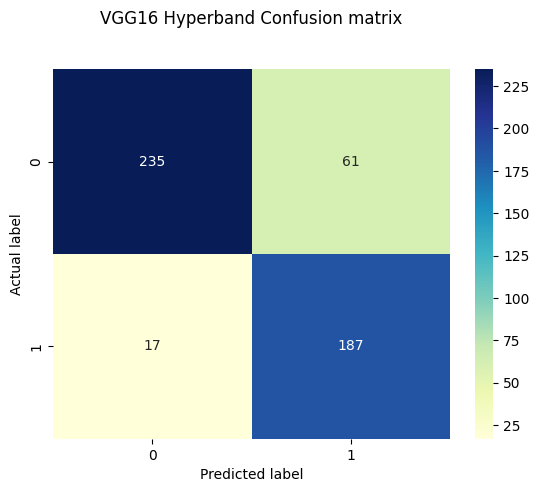

In [52]:
vgg16_hyperband_prediction = vgg16_hyperband.predict(test_data)
cnf_matrix = confusion_matrix(test_labels, np.round(vgg16_hyperband_prediction))

p = sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
plt.title('VGG16 Hyperband Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

print(classification_report(test_labels, np.round(vgg16_hyperband_prediction)))

### RandomSearch

16/16 [==============================] - 1s 35ms/step
              precision    recall  f1-score   support

           0       0.96      0.80      0.87       296
           1       0.77      0.95      0.85       204

    accuracy                           0.86       500
   macro avg       0.86      0.87      0.86       500
weighted avg       0.88      0.86      0.86       500



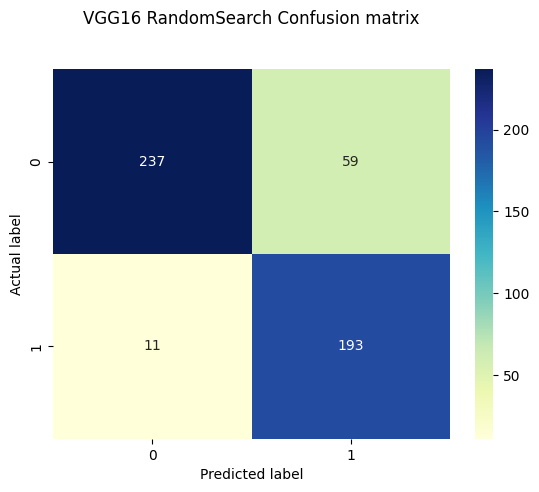

In [54]:
vgg16_randomsearch_prediction = vgg16_randomsearch.predict(test_data)
cnf_matrix = confusion_matrix(test_labels, np.round(vgg16_randomsearch_prediction))

p = sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
plt.title('VGG16 RandomSearch Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

print(classification_report(test_labels, np.round(vgg16_randomsearch_prediction)))

### Bayesian

16/16 [==============================] - 1s 38ms/step
              precision    recall  f1-score   support

           0       0.89      0.88      0.88       296
           1       0.82      0.84      0.83       204

    accuracy                           0.86       500
   macro avg       0.85      0.86      0.86       500
weighted avg       0.86      0.86      0.86       500



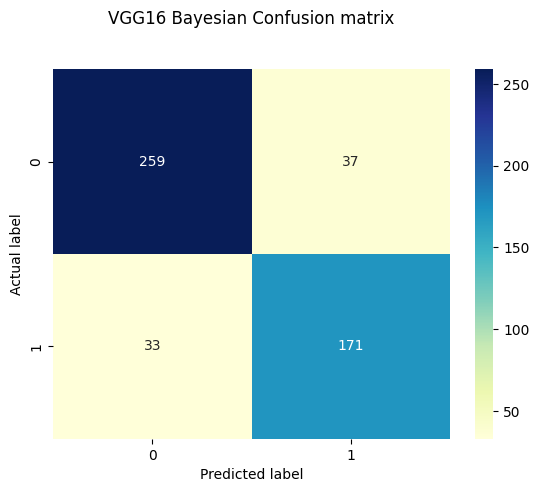

In [55]:
vgg16_bayesian_prediction = vgg16_bayesian.predict(test_data)
cnf_matrix = confusion_matrix(test_labels, np.round(vgg16_bayesian_prediction))

p = sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
plt.title('VGG16 Bayesian Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

print(classification_report(test_labels, np.round(vgg16_bayesian_prediction)))

1/1 [==============================] - 0s 22ms/step


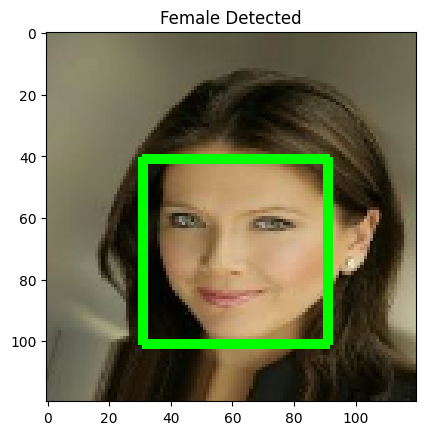

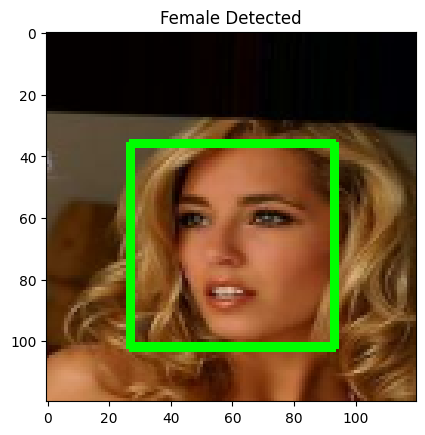

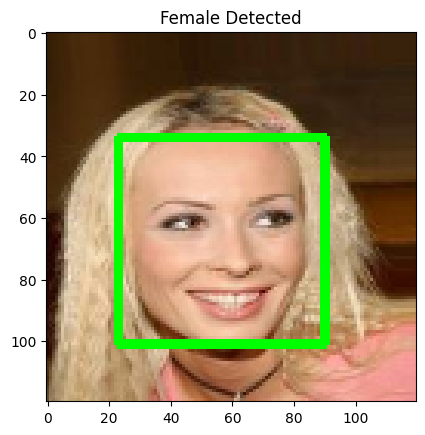

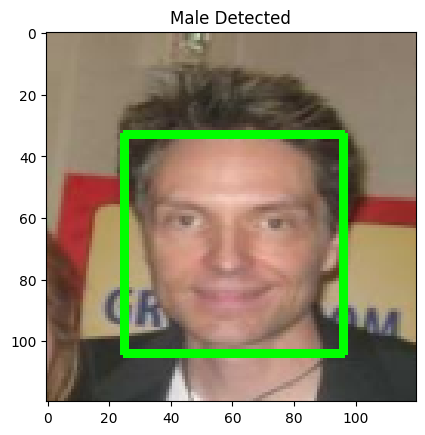

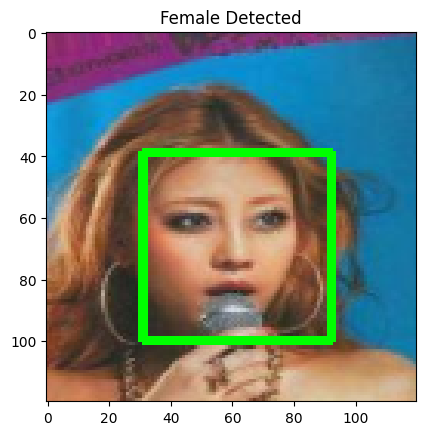

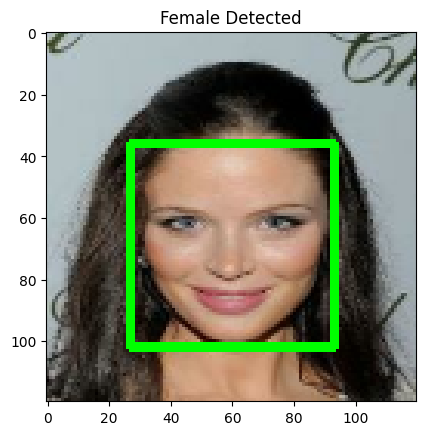

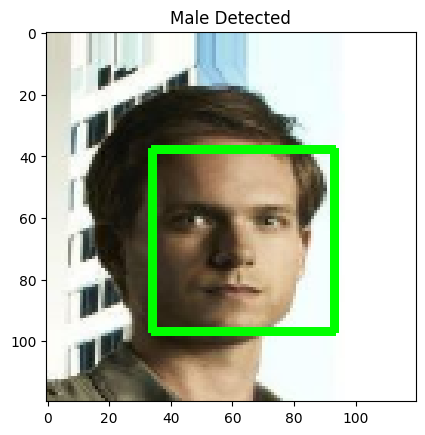

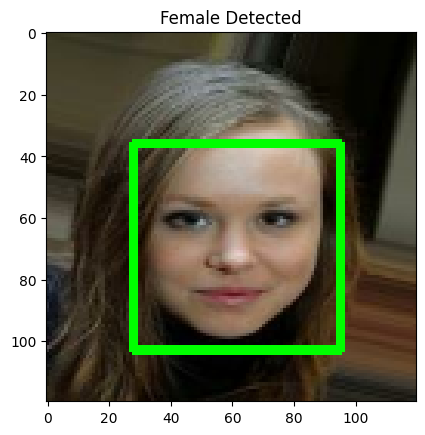

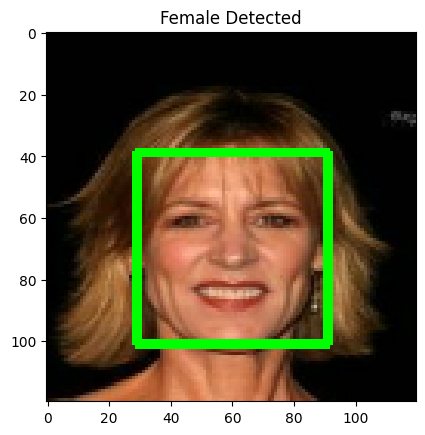

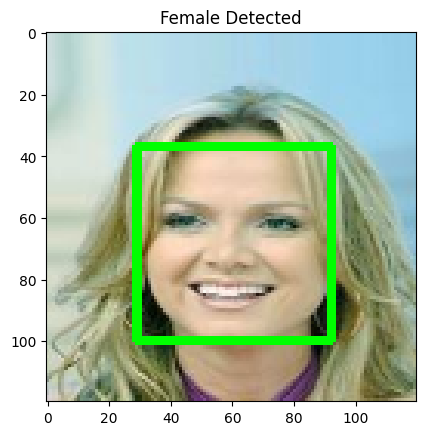

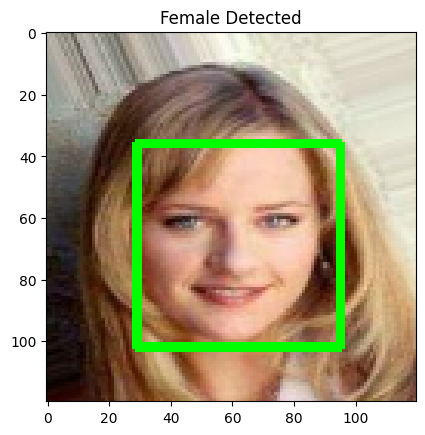

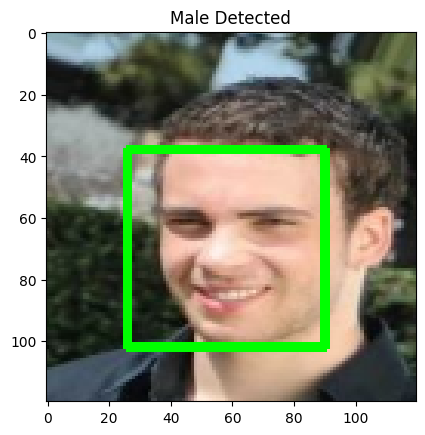

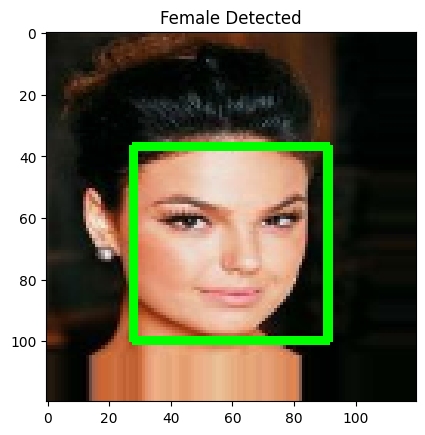

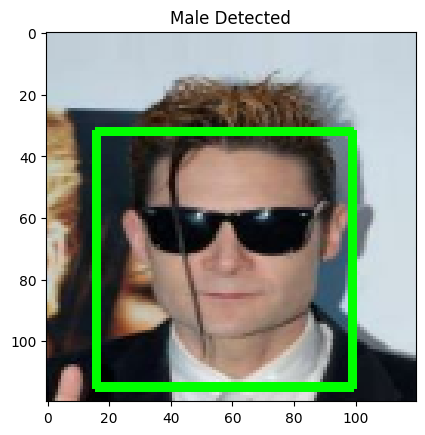

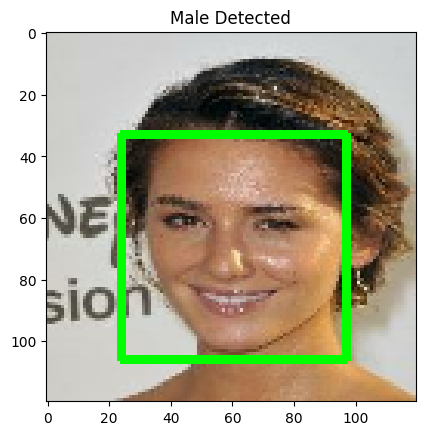

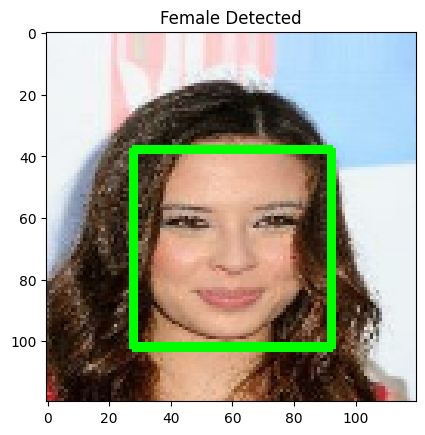

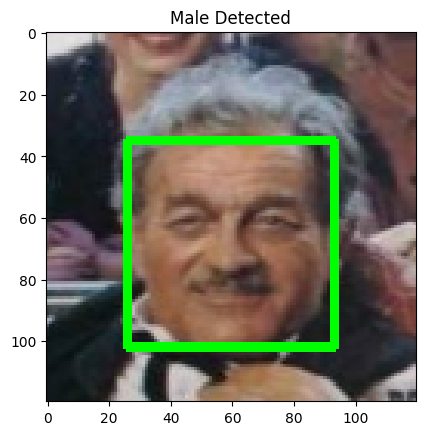

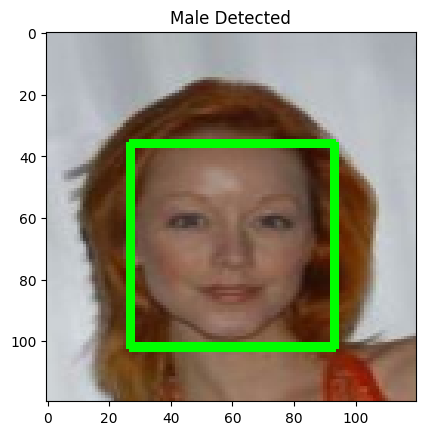

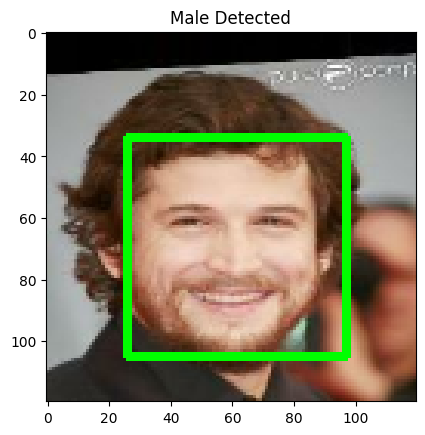

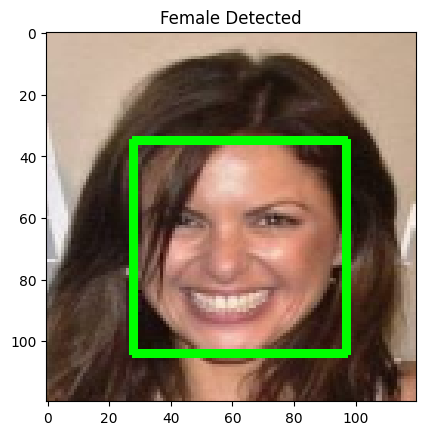

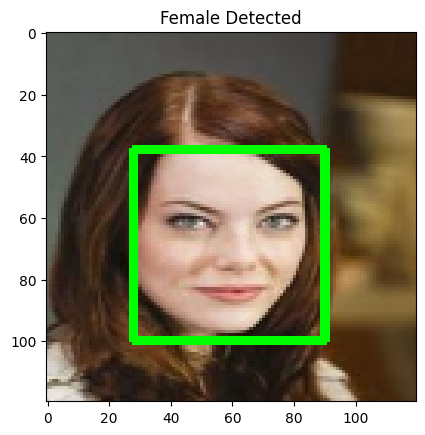

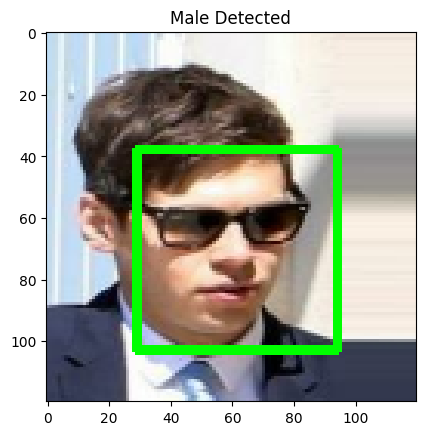

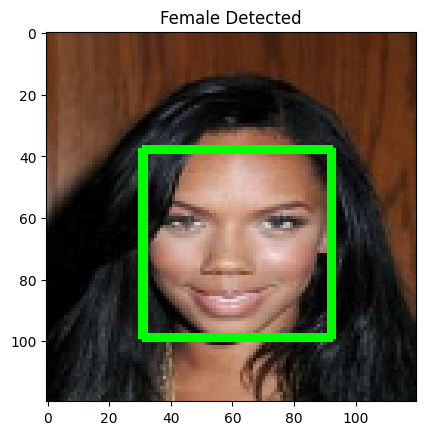

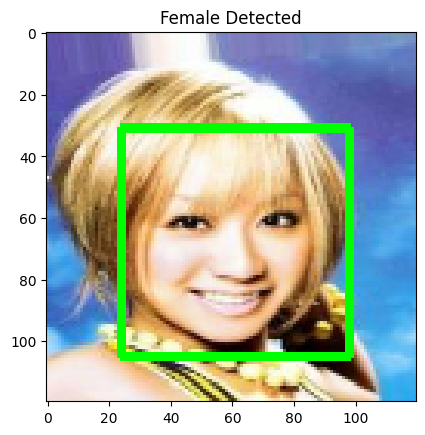

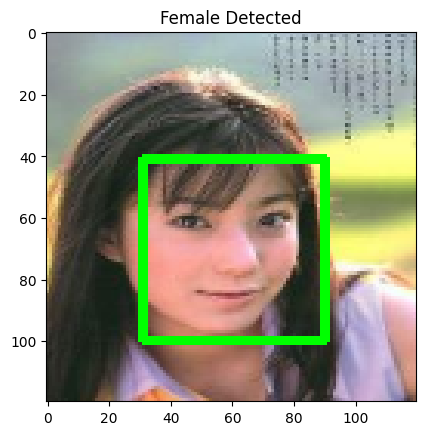

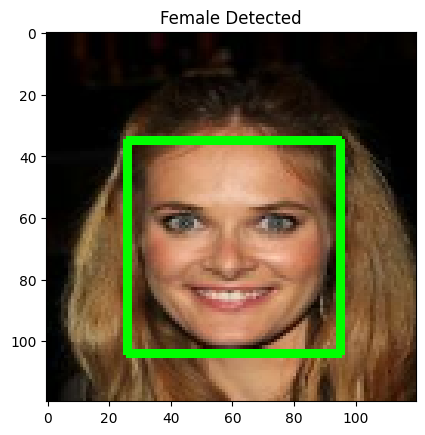

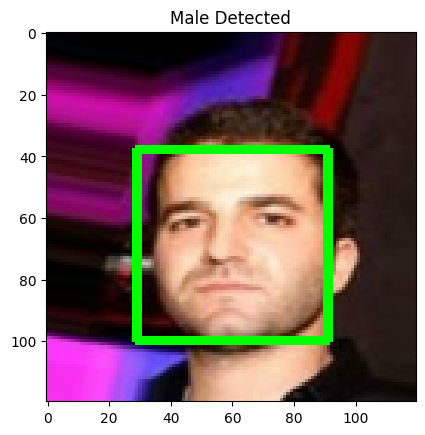

In [42]:
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
for images, labels in test_datasets.take(1):
    predicts = vgg16_hyperband.predict(images)
    for image, predict in zip(images, predicts):
        image = np.array(image, dtype='uint8')
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, 1.3, 5)

        for (x, y, w, h) in faces:
            if np.round(predict) == 0:
                cv2.rectangle(image, (x, y),((x + w), (y + h)), (0, 255, 0), 2)
                # cv2.putText(image, 'Female', (x, y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (0, 0, 255), 1)
                plt.imshow(image)
                plt.title('Female Detected')
                plt.show()
            else:
                cv2.rectangle(image, (x, y),((x + w), (y + h)), (0, 255, 0), 2)
                # cv2.putText(image, 'Male', (x, y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (0, 0, 255), 1)
                plt.imshow(image)
                plt.title('Male Detected')
                plt.show()
            
    break